# Imports

In [1]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

# Utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    """
    Takes the values from the target variable and the predictions
    and draws the graphs for each variable. 
    Saves plots to pdf with `plot_title`.pdf
    Parameters:
        y_test (pd.DataFrame): The validation target values.
        y_pred (pd.DataFrame): The predictions target values.
        plot_title (string, optional): The title of plot.
"""
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig("results/"+plot_title+'.pdf')
    plt.show()


def custom_train_test_split(X, y, test_size=0.2, drop=True, columns_to_drop=[]):
    """
    Splits the dataset into training and testing sets based on unique trajectory IDs.
    Parameters:
        X (pd.DataFrame): The feature dataset containing a 'trajectory_id' column.
        y (pd.DataFrame): The target dataset containing a 'trajectory_id' column.
        test_size (float, optional): The proportion of the dataset to include in the test split. Default is 0.2.
        drop (Boolean): Helper flag to decide weather to drop any columns or not
        columns_to_drop (list, optional): List of columns to drop from the feature dataset. Default is an empty list.
    Returns:
        tuple: A tupple containing the following:
            - X_train (pd.DataFrame): The training set of the feature dataset.
            - X_test (pd.DataFrame): The testing set of the feature dataset.
            - y_train (pd.DataFrame): The training set of the target dataset.
            - y_test (pd.DataFrame): The testing set of the target dataset.
    """
    # Get unique trajectory_ids
    unique_ids = X['trajectory_id'].unique()
    
    # Split the trajectory_ids into train and test sets
    train_ids, test_ids = train_test_split(unique_ids, test_size=test_size)

    # Split the data based on the trajectory_ids
    X_train = X[X['trajectory_id'].isin(train_ids)]
    X_test = X[X['trajectory_id'].isin(test_ids)]
    y_train = y[y['trajectory_id'].isin(train_ids)]
    y_test = y[y['trajectory_id'].isin(test_ids)]
    
    if drop:
        X_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop
        Y_columns_drop = ['trajectory_id', 'Id'] + columns_to_drop

        # Drop the specified columns from X and y
        X_train = X_train.drop(columns=X_columns_drop)
        X_test = X_test.drop(columns=X_columns_drop)
        y_train = y_train.drop(columns=Y_columns_drop)
        y_test = y_test.drop(columns=Y_columns_drop)
    
    return X_train, X_test, y_train, y_test

# Rename function - GRID Search sklean
def train_model(pipeline: Pipeline,
                   X_train: pd.DataFrame, 
                   X_val: pd.DataFrame,
                   y_train: pd.DataFrame,
                   y_val: pd.DataFrame):
    """
    Evaluates the performance of a machine learning model pipeline on given data.

    This function splits the data into training and testing sets using a custom split function,
    fits the model pipeline on the training data, and then evaluates the model's performance
    on both the training and testing sets. It prints the mean squared error for both sets.

    Parameters:
        pipeline (Pipeline): The machine learning pipeline to be evaluated.
        X (pd.DataFrame): The input features for the model.
        y (pd.DataFrame): The target values for the model.
    Returns:
        y_pred_train: The prediction of the train dataset
        y_pred_val: The prediction of the validation dataset
        model: The model created
    """
    # Creates a model based on the pipeline passed
    model = pipeline.fit(X_train, y_train)
    # Check performance on train
    y_pred_train = model.predict(X_train)

    # Check performance on val
    y_pred_val = model.predict(X_val)
    return y_pred_train, y_pred_val, model

def validate_poly_regression(X_train: pd.DataFrame,
                             y_train: pd.DataFrame,
                             X_val: pd.DataFrame,
                             y_val: pd.DataFrame,
                             regressor=None, 
                             degrees=range(1,15), 
                             max_features=None,
                             plot=False
                            ):

    best_rmse = float('inf')
    best_model = None
    best_degree = None

    for degree in degrees:
        model = make_pipeline(StandardScaler() ,PolynomialFeatures(degree=degree), regressor if regressor else LinearRegression())

        # Fit the pipeline on the training data
        print("Fitting the model")
        model.fit(X_train, y_train)

        # Predict on the training model
        y_pred_train = model.predict(X_train)
        print("rmse for training: "+str(root_mean_squared_error(y_train, y_pred_train)))

        # Predict on the validation data
        print("Preddicting the model")
        y_pred = model.predict(X_val)

        # Calculate RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Print the number of features generated by PolynomialFeatures
        num_features = model.named_steps['polynomialfeatures'].n_output_features_
        print(f"Degree: {degree}, RMSE: {rmse}, Number of features: {num_features}")

        if plot:
            # How to plot the polynomial regression associated with each feature
            print()

        # Update the best model if the current one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_degree = degree

    print(f"Best Degree: {best_degree}, Best RMSE: {best_rmse}")
    return best_model, best_rmse



In [3]:
df = pd.read_csv("../data/mlNOVA/mlNOVA/X_train.csv")

# Model Analysis for the Three Body Problem
## The problem
The problem consists in predicting positions at an instant t given a set of initial positions. 
This problem will be aproached as a multivariate regression, and we'll compare the results of using different types of regressions.

In [4]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]
df[df['trajectory_id'] == 157]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,trajectory_id
40349,0.000000,1.000000,0.000000,0.000000,0.000000,-0.006029,0.411829,0.000000,0.000000,-0.993971,-0.411829,0.000000,0.000000,40349,157
40350,0.039062,0.999222,0.000207,-0.039848,0.010623,-0.005786,0.411289,0.012472,-0.027653,-0.993436,-0.411497,0.027376,0.017030,40350,157
40351,0.078125,0.996885,0.000830,-0.079867,0.021279,-0.005053,0.409668,0.025035,-0.055369,-0.991831,-0.410499,0.054831,0.034089,40351,157
40352,0.117188,0.992978,0.001871,-0.120228,0.032003,-0.003827,0.406962,0.037782,-0.083211,-0.989151,-0.408833,0.082446,0.051208,40352,157
40353,0.156250,0.987485,0.003332,-0.161116,0.042829,-0.002098,0.403165,0.050812,-0.111244,-0.985387,-0.406497,0.110303,0.068415,40353,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40601,9.843750,-2.502845,0.957132,-0.401091,0.204687,1.165911,-0.700134,0.690975,0.042212,1.336935,-0.256998,-0.289884,-0.246899,40601,157
40602,9.882810,-2.518426,0.965095,-0.396626,0.202979,1.194048,-0.695157,0.748944,0.217154,1.324377,-0.269938,-0.352318,-0.420133,40602,157
40603,9.921880,-2.533833,0.972990,-0.392213,0.201291,1.224357,-0.682701,0.801769,0.428515,1.309476,-0.290289,-0.409556,-0.629806,40603,157
40604,9.960940,-2.549068,0.980821,-0.387851,0.199620,1.256559,-0.660818,0.844334,0.707369,1.292509,-0.320003,-0.456483,-0.906990,40604,157


## Data Preparation

In [5]:
# Cleaning the data
# Create the trajectory_id column
df['trajectory_id'] = df['Id'] // 257
# Filter out rows where all columns except 'Id' and trajectory_Id are zero
df_filtered = df.loc[~(df.drop(columns=['Id','trajectory_id']) == 0).all(axis=1)]

# Features
# Group by 'trajectory_id' and get the first occurrence of each group
first_occurrence = df_filtered.groupby('trajectory_id').first().reset_index()
# Merge first occurrence back to the original dataframe, only replacing columns that need to be kept constant
columns_to_replace = df_filtered.columns.difference(['t', 'trajectory_id', 'Id'])  # Columns to replace except 't' and 'trajectory_id'
# We merge 'first_occurrence' on 'trajectory_id' with the original dataframe,
# and only replace the required columns.
X_raw = df_filtered[['t', 'trajectory_id', 'Id']].merge(
    first_occurrence[['trajectory_id'] + list(columns_to_replace)],
    on='trajectory_id',
    how='left'
)
# Reorder the columns
X_raw = X_raw[['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
#print(X_raw)

# Target
Y_raw = df_filtered[['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id', 'trajectory_id']]
#print(Y_raw)

# Permanent test data
# First, remove 10% of the data to use as a fixed test set
X_train_val, X_test, y_train_val, y_test = custom_train_test_split(X_raw, Y_raw, test_size=0.1, drop=False)
X_test.drop(columns=['trajectory_id', 'Id'])
y_test.drop(columns=['trajectory_id', 'Id'])

X = X_train_val
y = y_train_val

## Linear Regression
Use the separate cell to run the split just once

In [10]:
# Test multiple Linear Regressions - also predict for the test model
X_train, X_val, y_train, y_val = custom_train_test_split(X, y, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])

Normal linear regression
train: 1.3395101214821958
validation: 1.2849159338932366


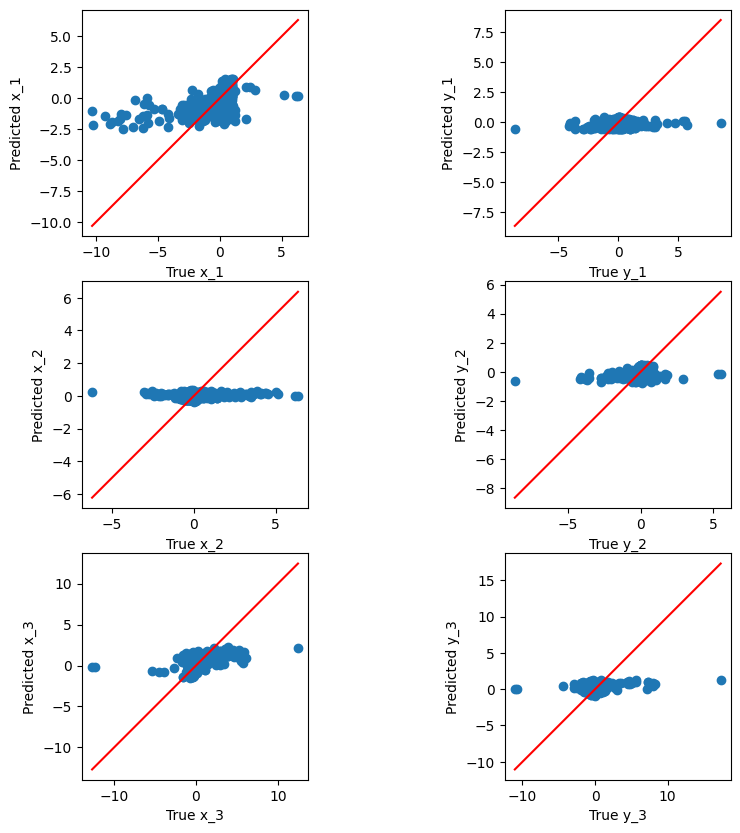

Regularizations
Ridge regression
train: 1.3395321505250661
validation: 1.2849006763198674


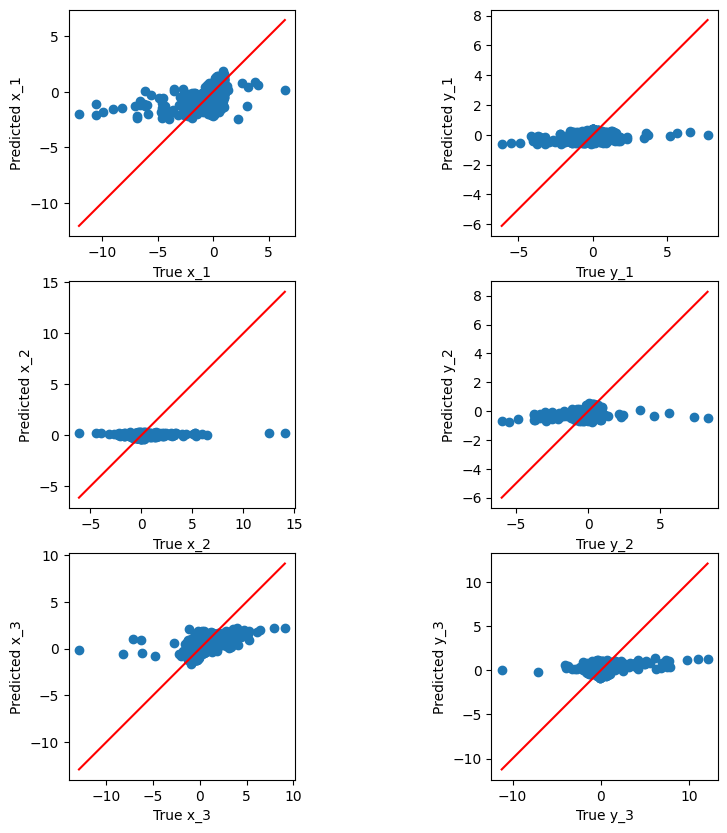

Lasso regression
train: 1.428209295662641
validation: 1.369072651132881


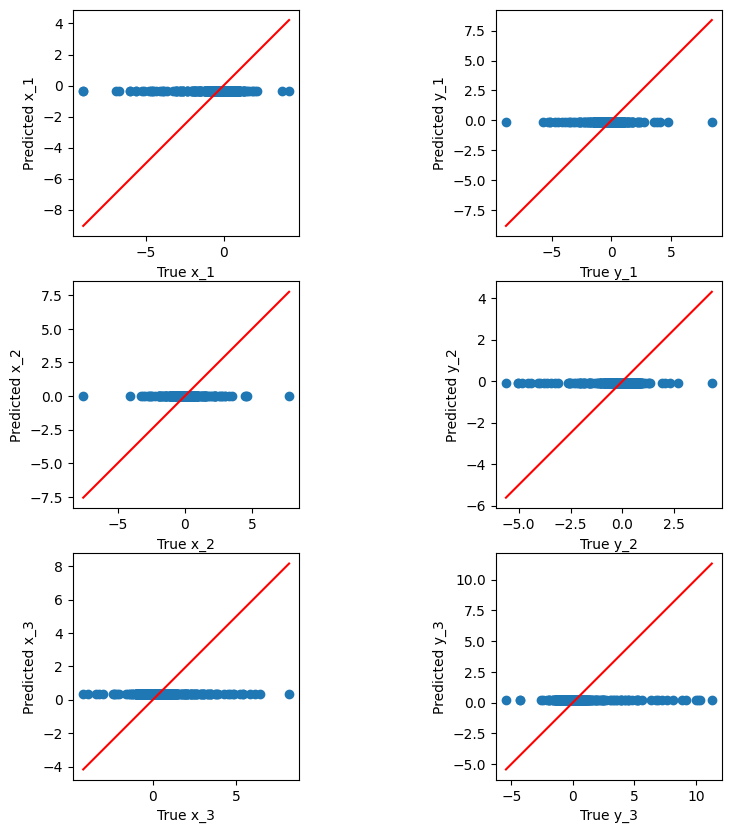

In [11]:
# Try with different hyper parameters

print("Normal linear regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression()) 
])
y_pred_train, y_pred_val, linear_model = train_model(pipeline, X_train, X_val, y_train, y_val)

print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression")

print("Regularizations")
print("Ridge regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])
y_pred_train, y_pred_val, linear_model_ridge = train_model(pipeline, X_train, X_val, y_train, y_val)
print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression Ridge")

print("Lasso regression")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=5))
])
y_pred_train, y_pred_val, linear_model_lasso = train_model(pipeline, X_train, X_val, y_train, y_val)
print("train: "+str(root_mean_squared_error(y_pred_train, y_train)))
print("validation: "+str(root_mean_squared_error(y_pred_val, y_val)))
plot_y_yhat(np.array(y_val), np.array(y_pred_val), "Linear Regression Lasso")

## Polynomial Linear Regressions

In [7]:
# Get one percent of data - too many features cannot be fitted 
X_train, _, y_train, _  = custom_train_test_split(X, y, 0.99, False)
X_train, X_val, y_train, y_val,  = custom_train_test_split(X_train, y_train, drop=True, columns_to_drop=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'])
print(X_train.shape)
print(y_train.shape)

# Standard regressor
best_model, best_rmse = validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1,10), plot=True) 
print(f"Best model: {best_model}, Best RMSE: {best_rmse}")

# Ridge
best_model, best_rmse = validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1,10), regressor=Ridge()) 
print(f"Best model: {best_model}, Best RMSE: {best_rmse}")

# Lasso
best_model, best_rmse = validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1,10), regressor=Lasso()) 
print(f"Best model: {best_model}, Best RMSE: {best_rmse}")

(7920, 7)
(7920, 6)
Fitting the model
rmse for training: 1.0431029118696828
Preddicting the model
Degree: 1, RMSE: 1.2300389924668436, Number of features: 8

Fitting the model
rmse for training: 0.9189188419501754
Preddicting the model
Degree: 2, RMSE: 1.4321929320216098, Number of features: 36

Fitting the model
rmse for training: 0.9742657760606283
Preddicting the model
Degree: 3, RMSE: 2.3992452674150546, Number of features: 120

Fitting the model
rmse for training: 0.7377224665198406
Preddicting the model
Degree: 4, RMSE: 2.6439497974032267, Number of features: 330

Fitting the model
rmse for training: 0.6965219007080287
Preddicting the model
Degree: 5, RMSE: 7.434499198955628, Number of features: 792

Fitting the model
rmse for training: 0.42785419650126705
Preddicting the model
Degree: 6, RMSE: 92.65607000431464, Number of features: 1716

Fitting the model
rmse for training: 0.2820227450386754
Preddicting the model
Degree: 7, RMSE: 3261294493012.817, Number of features: 3432

Fit